# The Role of NDVI in Surface Temperatures of urban areas
[Repo Link](https://github.com/Lutzkk/urban_programming)

In [1]:
import ee 
import os
import geemap 
import xarray as xr 
import rioxarray as rxr
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import geopandas as gpd
from rasterio.enums import Resampling
from scipy.stats import pearsonr

In [ ]:
#wd setting
wd = '/home/lutz/master/code/second_sem/urban/presentation/code'
os.chdir(wd)
print('Current working directory:', os.getcwd())

# FOR BINDER USERS -> Uncomment the following lines and replace the 3 lines above with them
#wd = os.path.dirname(os.path.abspath("__file__"))
#os.chdir(wd)
#print("Current working directory:", os.getcwd())

Current working directory: /home/lutz/master/code/second_sem/urban/presentation/code


In [ ]:
ee.Authenticate() 
ee.Initialize(project="ee-lutz-training") #Authenticate with your Google account !!Insert your project name here!! 

True

## Loading the AOI's

In [4]:
munich=gpd.read_file("../data/aoi_munich.geojson").to_crs("EPSG:4326")
cologne=gpd.read_file("../data/aoi_cologne.geojson").to_crs("EPSG:4326")

#extract geometry
munich_geom=munich.geometry.iloc[0]
cologne_geom=cologne.geometry.iloc[0]

#convert geometry info to GeoJSON dict
munich_geojson=munich_geom.__geo_interface__
cologne_geojson=cologne_geom.__geo_interface__

#create EE Geometry
munich_ee=ee.Geometry(munich_geojson)
cologne_ee=ee.Geometry(cologne_geojson)
#plot map using geemap
Map = geemap.Map()  # zoomed out to show both cities
Map.add_gdf(munich, layer_name="Munich AOI")
Map.add_gdf(cologne, layer_name="Cologne AOI")
Map.add_basemap("OpenStreetMap")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [5]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)


munich_props=(
  ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
  .filterDate("2024-06-01","2024-08-31")
  .filterBounds(munich_ee)
  .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 15))
  .map(mask_s2_clouds)
  .map(lambda img: img.clip(munich_ee))
  .map(lambda img: img.select(["B8", "B4", "B3", "B2"]).rename(["Nir","Red", "Green", "Blue"]))
  .map(lambda img: img.addBands(img.normalizedDifference(['Nir', 'Red']).rename('NDVI')))  

) 
footprint = munich_props.geometry()
Map.addLayer(footprint, {'color': 'red'}, 'Image footprints')


munich_median = munich_props.median()

#plotting the images
Map = geemap.Map()
Map.centerObject(munich_ee, 11)  # Center on Munich AOI

# Add median true-color composite
Map.addLayer(munich_median, {'bands': ['Red', 'Green', 'Blue'], 'min': 0, 'max': 0.2}, 'Munich Median RGB')
Map.addLayer(munich_ee, {}, 'Munich AOI')
Map.addLayer(munich_geom, {}, 'Munich AOI')
ndvi_viz = {
    'min': 0.0,
    'max': 1,
    'palette': ['blue', 'white', 'green'],
}
Map.addLayer(munich_median.select('NDVI'), ndvi_viz, 'Munich NDVI')

# Export Munich RGB and NDVI
task = ee.batch.Export.image.toDrive(
    image=munich_median,
    description='Munich_RGB_NDVI',
    folder='earthengine_exports',
    fileNamePrefix='munich',
    region=munich_ee,
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
#task.start()
Map


Map(center=[48.132922610584714, 11.55364963105928], controls=(WidgetControl(options=['position', 'transparent_…

In [6]:
cologne_props=(
  ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
  .filterDate("2024-06-01","2024-08-31")
  .filterBounds(cologne_ee)
  .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 15))
  .map(mask_s2_clouds)
  .map(lambda img: img.clip(cologne_ee))
  .map(lambda img: img.select(["B8", "B4", "B3", "B2"]).rename(["Nir","Red", "Green", "Blue"]))
  #ndvi calc
  .map(lambda img: img.addBands(img.normalizedDifference(['Nir', 'Red']).rename('NDVI')))
)

cologne_median = cologne_props.median()

# Export Cologne RGB and NDVI
task_cologne = ee.batch.Export.image.toDrive(
    image=cologne_median,
    description='Cologne_RGB_NDVI',
    folder='earthengine_exports',
    fileNamePrefix='cologne_',
    region=cologne_ee,
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
#task_cologne.start()

## Post Download Data Preprocessing
We downloaded RGB + NIR and NDVI Data as a multiband raster (tif) to have a quick visual check if ndvi and rgb aligns. For the sake of storage and computational efficiency we extract the NDVI band and save it as a nc file for better compatibility with Xarray.


Tifs dont exist (most likely already converted to netcdf and deleted - Skipping this step)
LST Tifs dont exist (most likely already converted to netcdf and deleted - Skipping this step)
converted munich tif not found, skipping removal
converted cologne tif not found, skipping removal
converted munich lst tif not found, skipping removal
converted cologne lst tif not found, skipping removal


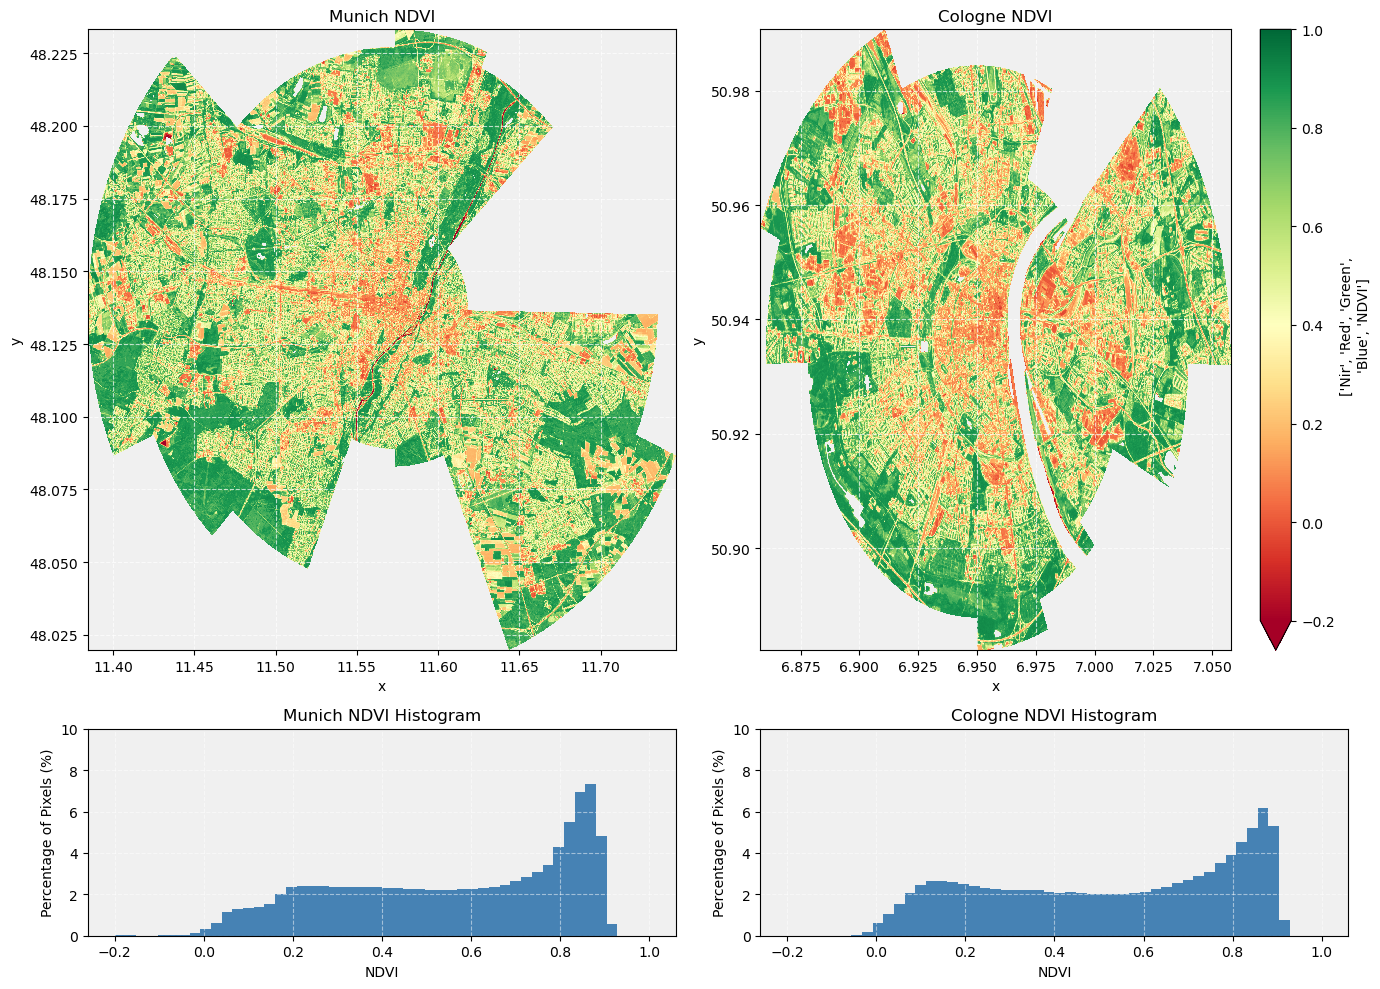

In [7]:
#--------NDVI AND RGB NETCDF4 CONVERSION-----------------
if os.path.exists("../data/munich_ndvi.tif") and os.path.exists("../data/cologne_ndvi.tif"):
    munich_p="../data/munich.tif"
    cologne_p="../data/cologne.tif"

    munich=rxr.open_rasterio(munich_p).isel(band=4).squeeze() 
    cologne=rxr.open_rasterio(cologne_p).isel(band=4).squeeze()

    munich.to_netcdf("../data/munich_ndvi.nc")
    cologne.to_netcdf("../data/cologne_ndvi.nc")
else:
    print("Tifs dont exist (most likely already converted to netcdf and deleted - Skipping this step)")



#---------LST NETCDF4 CONVERSION-----------------

if os.path.exists("../data/munich_lst.tif") and os.path.exists("../data/cologne_lst.tif"):
    munich_lst_p="../data/munich_lst.tif"
    cologne_lst_p="../data/cologne_lst.tif"

    munich_lst=xr.open_dataarray(munich_lst_p).squeeze().to_netcdf("../data/munich_lst.nc")
    cologne_lst=xr.open_dataarray(cologne_lst_p).squeeze().to_netcdf("../data/cologne_lst.nc")
    print("LST Conversion for munich and cologne completed")
else:
    print("LST Tifs dont exist (most likely already converted to netcdf and deleted - Skipping this step)")



#--------REMOVE OLD FILES-----------------
files = [
    ("../data/munich.tif", "converted munich tif"),
    ("../data/cologne.tif", "converted cologne tif"),
    ("../data/munich_lst.tif", "converted munich lst tif"),
    ("../data/cologne_lst.tif", "converted cologne lst tif"),
]

for filepath, description in files:
    if os.path.exists(filepath):
        print(f"Removing {description}")
        os.remove(filepath)
    else:
        print(f"{description} not found, skipping removal")


#open netcdf files 
munich=xr.open_dataset("../data/munich_ndvi.nc")
munich = munich["__xarray_dataarray_variable__"].rename("ndvi").rio.write_crs("EPSG:4326").drop_vars("band")
cologne=xr.open_dataset("../data/cologne_ndvi.nc")
cologne = cologne["__xarray_dataarray_variable__"].rename("ndvi").rio.write_crs("EPSG:4326").drop_vars("band")
munich_lst=xr.open_dataset("../data/munich_lst.nc")
munich_lst = munich_lst["__xarray_dataarray_variable__"].rename("lst").rio.write_crs("EPSG:4326").drop_vars("band")
cologne_lst=xr.open_dataset("../data/cologne_lst.nc")
cologne_lst = cologne_lst["__xarray_dataarray_variable__"].rename("lst").rio.write_crs("EPSG:4326").drop_vars("band")

#--------PLOTTING-----------------
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])  


# --- Munich map ---
ax0 = fig.add_subplot(gs[0, 0])
munich.plot(ax=ax0, cmap='RdYlGn', vmin=-0.2, vmax=1, add_colorbar=False)
ax0.set_title('Munich NDVI')
ax0.set_facecolor("#f0f0f0")
ax0.grid(True, which="both", linestyle="--", color="white", alpha=0.7)

# --- Munich histogram ---
ax1 = fig.add_subplot(gs[1, 0])
n, bins, _ = ax1.hist(
    munich.values.ravel(),
    bins=50,
    range=(-0.2, 1),
    color='steelblue',
    density=True,
)
bin_width = bins[1] - bins[0]
n_percent = n * bin_width * 100
ax1.cla()  # clear old histogram
ax1.bar(bins[:-1], n_percent, width=bin_width, color='steelblue', align='edge')
ax1.set_title('Munich NDVI Histogram')
ax1.set_xlabel('NDVI')
ax1.set_ylabel('Percentage of Pixels (%)')
ax1.set_ylim(0, 10)
ax1.set_facecolor("#f0f0f0")
ax1.grid(True, which="both", linestyle="--", color="white", alpha=0.5)

# --- Cologne map ---
ax2 = fig.add_subplot(gs[0, 1])
cologne.plot(ax=ax2, cmap='RdYlGn', vmin=-0.2, vmax=1, add_colorbar=True)
ax2.set_title('Cologne NDVI')
ax2.set_facecolor("#f0f0f0")
ax2.grid(True, which="both", linestyle="--", color="white", alpha=0.7)

# --- Cologne histogram ---
ax3 = fig.add_subplot(gs[1, 1])
n, bins, _ = ax3.hist(
    cologne.values.ravel(),
    bins=50,
    range=(-0.2, 1),
    color='steelblue',
    density=True,
)
n_percent = n * bin_width * 100
ax3.cla()  # clear old histogram
ax3.bar(bins[:-1], n_percent, width=bin_width, color='steelblue', align='edge')
ax3.set_title('Cologne NDVI Histogram')
ax3.set_xlabel('NDVI')
ax3.set_ylabel('Percentage of Pixels (%)')
ax3.set_ylim(0, 10)
ax3.set_facecolor("#f0f0f0")
ax3.grid(True, which="both", linestyle="--", color="white", alpha=0.5)

plt.tight_layout()
plt.show()

# Datacube Creation and spatial correlation
We will now employ Xarray to look for a spatial correlation between **LST** and **NDVI**

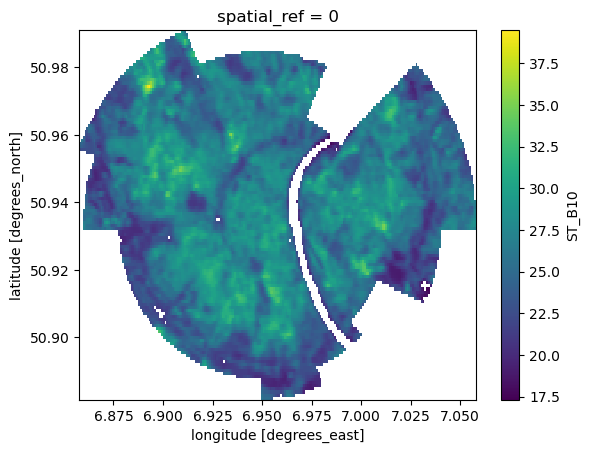

In [8]:
munich_ndvi=munich.rio.reproject_match(munich_lst, resampling=Resampling.average)
ds_munich=xr.Dataset({
    "ndvi": munich_ndvi,
    "lst": munich_lst
})
mask_munich = ~np.isnan(ds_munich['ndvi']) & ~np.isnan(ds_munich['lst'])
ds_munich['ndvi'] = ds_munich['ndvi'].where(mask_munich)
ds_munich['lst'] = ds_munich['lst'].where(mask_munich)


cologne_ndvi=cologne.rio.reproject_match(cologne_lst, resampling=Resampling.average)
ds_cologne=xr.Dataset({
    "ndvi": cologne_ndvi,
    "lst": cologne_lst
})
mask_cologne = ~np.isnan(ds_cologne['ndvi']) & ~np.isnan(ds_cologne['lst'])
ds_cologne['ndvi'] = ds_cologne['ndvi'].where(mask_cologne)
ds_cologne['lst'] = ds_cologne['lst'].where(mask_cologne)


ds_cologne['lst'].plot()


# Bivariate Spatial Correlation 
The concept of bivariate spatial correlation is complex. Typically the correlation between one variable and the spatial lag of another variable is considered.
Frequently used concepts: 
- **Bivariate Moran's I** -> Not suited since it only checks the spatial correlation of neighboring pixels and not of two overlaying pixels of different variables.
- **Lees L/Spatial Pearson** -> Probably best suited for the analysis, but not implemented in any package for Python 3.9.21 + pretty complex
- **Pearsons R** -> What we will do

## Understanding Pearson's r

The Pearson correlation coefficient (**r**) measures the strength and direction of a linear relationship between two continuous variables.

- **Range:** r varies from -1 to +1:
  - **r = +1** → perfect positive linear relationship (both variables increase together).
  - **r = -1** → perfect negative linear relationship (one variable increases while the other decreases).
  - **r = 0** → no linear relationship.

- **Interpretation in our context:**
  - Calculating Pearson’s r on per-pixel NDVI and LST values across the study area quantifies how strongly vegetation health relates to land surface temperature.
  - A **negative r** indicates that higher NDVI (more vegetation) is associated with lower LST (cooler surface), supporting the cooling effect of vegetation.

- **Statistical significance:**
  - The p-value from `pearsonr` tests the null hypothesis that the true correlation is zero.
  - A small p-value (e.g., p < 0.05) suggests the observed correlation is unlikely due to random chance.

- **Usage note:**
  - Pearson’s r only measures linear relationships.
  - Outliers, non-linear patterns, or spatial autocorrelation can affect the interpretation.

In this analysis, Pearson’s r provides a clear, quantitative summary of how vegetation (NDVI) relates to land surface temperature (LST) across all pixels.



In [9]:
munich_ndvi_flat = ds_munich['ndvi'].where(mask_munich).values.flatten()
munich_lst_flat = ds_munich['lst'].where(mask_munich).values.flatten()

munich_valid = (~np.isnan(munich_ndvi_flat)) & (~np.isnan(munich_lst_flat))

munich_ndvi_clean = munich_ndvi_flat[munich_valid]
munich_lst_clean = munich_lst_flat[munich_valid]


corr, pval = pearsonr(munich_ndvi_clean, munich_lst_clean)
print(f"Pearson correlation for Munich: {corr:.3f}, p-value: {pval:.10e}") 
#The p value of basically 0 implies that the probability of the correlation being random is smaller than what floating point precision can represent.
#This imples that we can be extremely confident that the correlation is not random and that there is a significant negative relationship between NDVI and LST.

#-------------------------------------------------------------------------

cologne_ndvi_flat = ds_cologne['ndvi'].where(mask_cologne).values.flatten()
cologne_lst_flat = ds_cologne['lst'].where(mask_cologne).values.flatten()

cologne_valid = (~np.isnan(cologne_ndvi_flat)) & (~np.isnan(cologne_lst_flat))

cologne_ndvi_clean = cologne_ndvi_flat[cologne_valid]
cologne_lst_clean = cologne_lst_flat[cologne_valid]

corr, pval = pearsonr(cologne_ndvi_clean, cologne_lst_clean)

print(f"Pearson correlation for Cologne: {corr:.3f}, p-value: {pval:.10e}")



Pearson correlation for Munich: -0.672, p-value: 0.0000000000e+00
Pearson correlation for Cologne: -0.749, p-value: 0.0000000000e+00


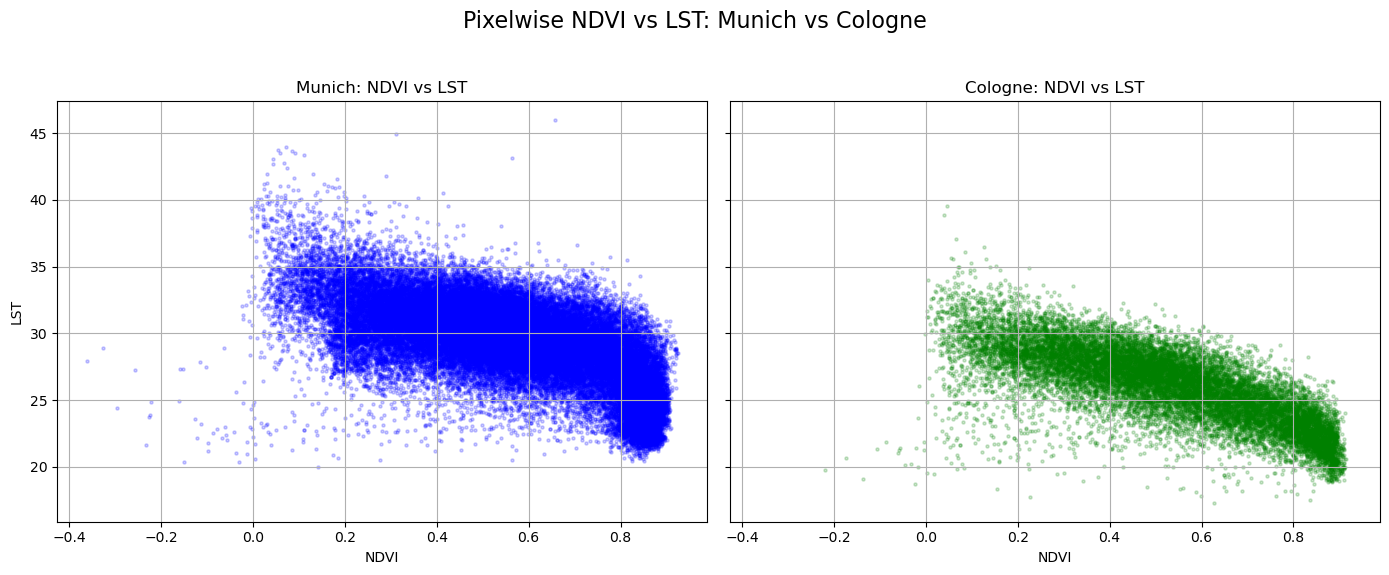

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Munich scatter
axes[0].scatter(munich_ndvi_clean, munich_lst_clean, s=5, alpha=0.2, color='blue')
axes[0].set_title("Munich: NDVI vs LST")
axes[0].set_xlabel("NDVI")
axes[0].set_ylabel("LST")
axes[0].grid(True)

# Cologne scatter
axes[1].scatter(cologne_ndvi_clean, cologne_lst_clean, s=5, alpha=0.2, color='green')
axes[1].set_title("Cologne: NDVI vs LST")
axes[1].set_xlabel("NDVI")
axes[1].grid(True)

plt.suptitle("Pixelwise NDVI vs LST: Munich vs Cologne", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
